# How has *The Queen's Gambit* impacted the popularity of online chess?

**Author:** David Zhang

All the code for the analyses in this jupyter notebook is publicly avaliable on [GitHub](https://github.com/dzhang32/chess). 

---

[*The Queen's Gambit*](https://en.wikipedia.org/wiki/The_Queen%27s_Gambit_(miniseries)) TV show depicts Beth Harmon, a chess prodigy who struggles with drug addiction, conquer a male-dominated chess world. It's no secret that the global success of *The Queen's Gambit* has caused a [recent surge in chess interest](https://www.nytimes.com/2020/11/23/arts/television/chess-set-board-sales.html). In fact, I myself am one of the victims, having been re-inspired to pick up online chess. Inevitably, this has snowballed into a bit of an addiction, having played [375 rapid games in the last month](https://www.chess.com/games/archive?gameOwner=my_game&gameType=live&gameTypeslive%5B%5D=rapid&rated=rated&endDate%5Bdate%5D=02/01/2021&startDate%5Bdate%5D=01/01/2021&timeSort=desc) and recieving 4 chess related books for my recent birthday. I've also noticed this chess craze rippling through socierty affecting my colleagues, friends and girlfriend. Conversations regarding chess have shifted from monologues to dialogues, with several friends opening the door to their first online chess games ever. 

This has lead me to wonder how many other's have been bitten by *The Queen's Gambit* bug and in particular, how this would be reflected in the popularity of online chess. I expect this would be identifiable through the following metrics: 
   
   1. An increase in the **number of new players** joining online chess websites. 
   2. An increase in the **number of games played by existing users**. 
    
Here, I try to test these hypotheses using the [chess.com](https://www.chess.com/) data, [the internet's largest chess community with over 28 million members](https://www.chessstrategyonline.com/play-chess-online). 

### Importing modules and setting plot styles

In [1]:
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {"figure.figsize": (11.7,8.27)})
sns.set_style("ticks")
sns.set_context("talk")

### 1. Number of new players
---

*The Queen's Gambit* was released on Netflix in the UK on the **23rd October 2020**. In order to see the impact of this on the number of players joining online chess, I'll use the [chess.com API](https://www.chess.com/news/view/published-data-api) to download UK player profiles that have joined within a 4 month window before or after October 23rd.

To begin, let's grab the joining date of players with the UK flag. To save time here (there's >200,000 UK players and it takes ~0.5s to query each player's profile), I've **randomly selected 5000 UK players**. It's worth noting that this approach is limited |by how accurately a user's flag reflects a user's country of residence during the period following *The Queen's Gambit* release. 

In [2]:
# parse timestamps as date times
dp = lambda x: datetime.fromtimestamp(int(x))

gb_join_dates_path = [path for path in os.listdir("data/") if "GB_players_joined" in path]

gb_join_dates = pd.read_csv("data/" + gb_join_dates_path[0], 
                            parse_dates = ["joined"], 
                            date_parser = dp)

gb_join_dates.head()

,user,joined
0,thinman8905,2021-01-10 14:12:00
1,johnoriel,2018-01-06 19:13:16
2,d1tjs,2020-11-16 12:18:48
3,teasingpenguin,2019-08-05 14:52:43
4,69legendlol,2020-07-20 17:29:37


With the joining dates downloaded and formatted, I can filter for those who have joined during our window of interest, namely 4 months before and after *The Queen's Gambit* release. 

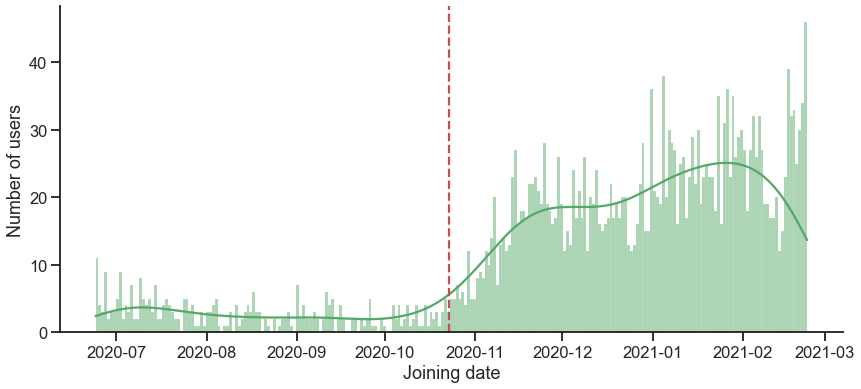

In [3]:
##### Data wrangling #####

def filter_dates_qg(join_dates, qg_date, months):
    
    earliest = qg_date - relativedelta(months = months)
    latest = qg_date + relativedelta(months = months)
    join_dates_qg = join_dates[(join_dates["joined"] >= earliest) & 
                               (join_dates["joined"] <= latest)].copy()
    
    return join_dates_qg

# set the QG release date
qg_date = datetime.strptime("2020-10-23", "%Y-%m-%d")

gb_join_dates_qg = filter_dates_qg(gb_join_dates, qg_date, 4)

# get number of days between our dates for use as bins for plotting
delta_days = (qg_date + relativedelta(months = 4)) - ((qg_date - relativedelta(months = 4)))
delta_days = delta_days.days

##### Plotting ######

fig = sns.displot(data = gb_join_dates_qg, 
                  x = "joined", 
                  bins = delta_days, 
                  kde = True, 
                  color = "g")

fig = fig.set(xlabel = "Joining date", ylabel = "Number of users")
fig.fig.set_figwidth(16)
fig.fig.set_figheight(6)
plt.axvline(qg_date, color = 'r', linestyle = "--")

After *The Queen's Gambit* UK release (marked with a <span style="color:red">red dashed line</span>) there's a dramatic and progressive increase in the number of user's joining chess.com (with the UK flag). Further observation would be needed to be sure, but it looks like this this explosion in user's signing up still growing to this day

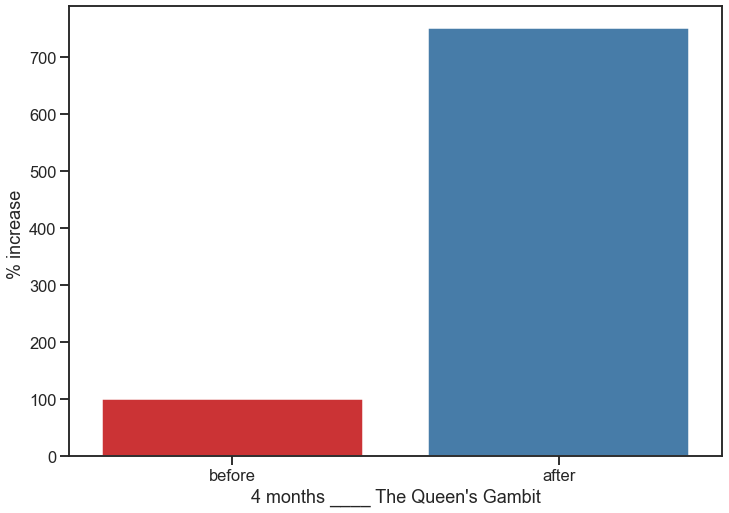

In [4]:
##### Data wrangling #####

# obtain a relative percentage of players joining before/after QG
gb_join_dates_qg.loc[:, ("qg")] = ["before" if date <= qg_date else "after" for date in gb_join_dates_qg["joined"]]
gb_join_dates_qg = gb_join_dates_qg.groupby("qg").count().reset_index()
gb_join_dates_qg["percent"] = (gb_join_dates_qg["joined"]/gb_join_dates_qg["joined"].min()) * 100

##### Plotting #####

fig = sns.barplot(data = gb_join_dates_qg,
                  x = "qg", 
                  y = "percent", 
                  order = ["before", "after"],
                  palette = "Set1")

fig = fig.set(xlabel = "4 months ____ The Queen's Gambit", 
              ylabel = "% increase ")

As a consequence, in total there has been **~7x** number of people joining chess.com in the 4 month window after *The Queen's Gambit* release compared to before.

The release date of shows on Netflix varies by country. This allows us to explore whether the increase in user's joining chess.com correlates with *The Queen's Gambit* release date in that specific country. Based off the [unofficial Netflix online global search](http://unogs.com/title/80234304), I selected 3 countries with different release dates and 1 where Netflix is not available: 

   1. **UK**: 23rd October 2020
   2. **Italy**: 28th November 2020
   3. **Columbia**: 12th January 2021
   4. **China**: Netflix unavailable
   
Again, 5000 players have been randomly chosen for each country and *The Queen's Gambit* release date. 

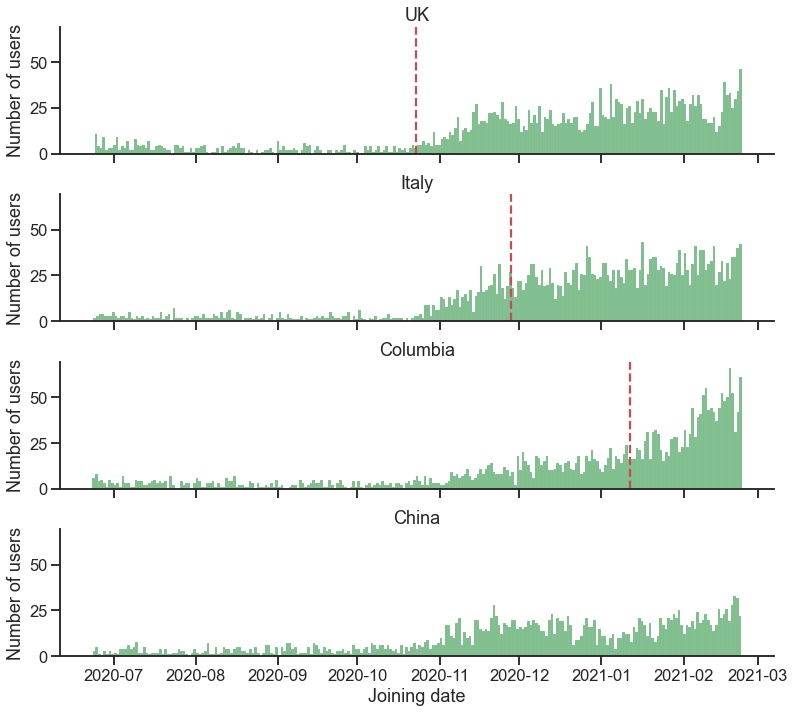

In [5]:
##### Data wrangling #####

join_dates_paths = [path for path in os.listdir("data/") if "players_joined" in path]

join_dates_all = []

# bind together join dates from all countries
for i in range(len(join_dates_paths)):

    join_dates = pd.read_csv("data/" + join_dates_paths[i], 
                             parse_dates = ["joined"], 
                             date_parser = dp)
    country = re.sub(r"_players.*", "", join_dates_paths[i])
    join_dates['country'] = country
    join_dates_all.append(join_dates)
    
join_dates_all = pd.concat(join_dates_all)

join_dates_all_qg = filter_dates_qg(join_dates_all, qg_date, 4)

##### Plotting #####

fig = sns.FacetGrid(data = join_dates_all_qg, 
                    row = "country",
                    row_order= ["GB", "IT", "CO", "CN"])

fig.map(sns.histplot, "joined", 
        bins = delta_days, 
        color = "g")

fig.set(xlabel = "Joining date", 
        ylabel = "Number of users")
fig.fig.set_figwidth(18)
fig.fig.set_figheight(10)

axes = fig.axes.flatten()
axes[0].set_title("UK")
axes[1].set_title("Italy")
axes[2].set_title("Columbia")
axes[3].set_title("China")
axes[0].axvline(qg_date, color = 'r', linestyle = "--")
axes[1].axvline(datetime.strptime("2020-11-28", "%Y-%m-%d"), color = 'r', linestyle = "--")
axes[2].axvline(datetime.strptime("2021-01-12", "%Y-%m-%d"), color = 'r', linestyle = "--")

It seems unclear whether the exact *The Queen's Gambit* release date marks the point when the number of user's joining starts to increase in that respective country. That being said, we can observe a shift in the peak of user's joining towards later dates in Columbia, the country with the most recent release date. Interestingly, from the 23rd October 2020 there is an increase in the number of players joining chess.com for all 4 countries. It's possible that this may be due to the availibity of VPNs and other *unofficial* methods, which can allow people to access Netflix shows outside of their country of residence. Consistently, the rate of increase in online chess uptake in China is substantially lower and looks to have has platea'd earlier than the other countries, potentially due to the greater online restrictions present there. 

### 2. Number of games played by existing users
---

*The Queen's Gambit* has gained popularity with the general public as an outstanding TV show, but has arguably been an even greater hit amongst chess fans. Even the current world champion [Magnus Carlsen endorsing it's games](https://www.youtube.com/watch?v=_ZfPa-GMxMI). Above, we explored the number of new players joining online chess, and here we focus instead on how existing user's have had their interest in chess re-kindled by *The Queen's Gambit*. 

To address this, I'll be continuing to use the 5000 random UK users obtained above. To ensure that this analysis is not confounded by the increase number of new players joining, I've only assessed the players that have joined before September 2020 (i.e. they've been part of chess.com for at least a month before the *The Queen's Gambit* release). Then, for the 5 month window between September 2020 - January 2021, I'll obtain the number of games played per month for each of these players.

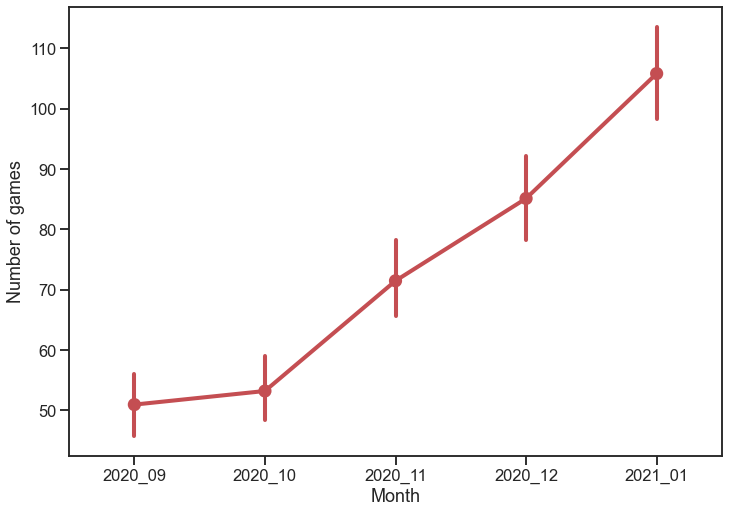

In [6]:
n_games = pd.read_csv("data/GB_n_games_27_02_2021.csv")

##### Plotting #####

fig = sns.pointplot(data = n_games,
                  x = 'month', 
                  y = 'n_games',
                  estimator = np.mean, 
                  color = "r")

fig = fig.set(xlabel = "Month", 
              ylabel = "Number of games")

From October onwards, we can see an steady rise in the average number of games played per player, suggesting *The Queen's Gambit* has motivated existing players to play more online chess. It's worth mentioning that a caveat for this analysis is that it's not split by time control (e.g. bullet, blitz, rapid etc), so there's a chance that this result could be explained by a shift towards faster time controls played.

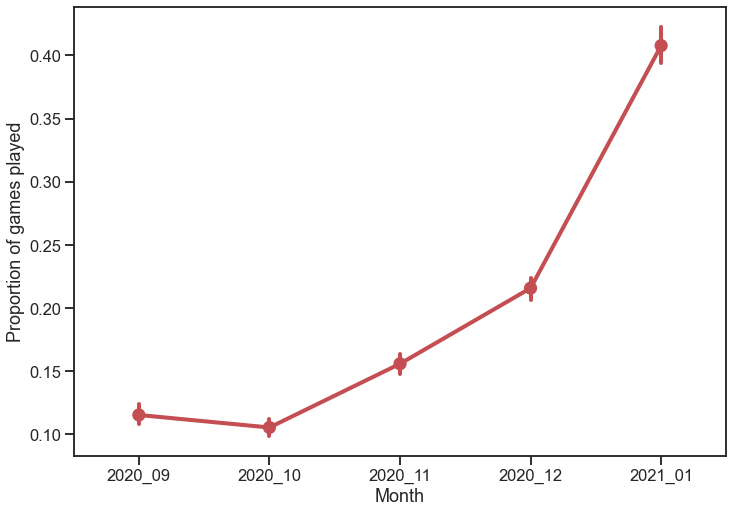

In [7]:
##### Data wrangling #####

n_games["prop_games"] = n_games.groupby(["username"]).n_games.apply(lambda x: x/np.sum(x))

# remove completely inactive players as these would have 
# infinite (NaN) proportions
n_games_no_inactive = n_games.loc[np.isfinite(n_games["prop_games"])]

##### Plotting #####

fig = sns.pointplot(data = n_games_no_inactive,
                    x = "month", 
                    y = "prop_games", 
                    estimator = np.mean, 
                    color = "r")

fig = fig.set(xlabel = "Month", 
              ylabel = "Proportion of games played")

By normalising the number of games played per player to a proportion across the 5 month window, we can investigate how individual players have increased their relative number of games played. Players have progressively increased in the frequency of their chess games played from September to January, suggesting that I am not alone in being influenced by the *The Queen's Gambit* to return to online chess.

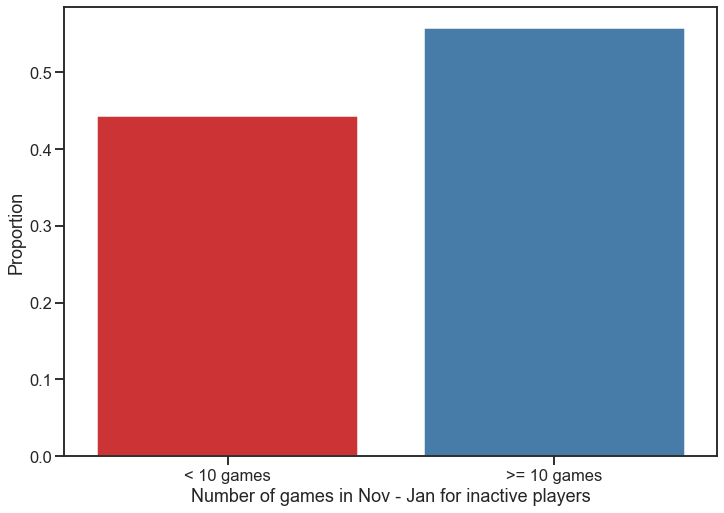

In [8]:
##### Data wrangling #####

# find which players were not playing in Sep and Oct
users_no_sep = n_games.loc[(n_games["month"] == "2020_09") & (n_games["n_games"] == 0)]["username"]
users_no_oct = n_games.loc[(n_games["month"] == "2020_10") & (n_games["n_games"] == 0)]["username"]
users_no_sep_oct = n_games.loc[n_games["username"].isin(users_no_sep) & n_games["username"].isin(users_no_oct)]

# find which players have started playing after Oct (at least 10 games)
playing_nov = users_no_sep_oct.groupby(["username"]).n_games.apply(lambda x: sum(x) >= 10).reset_index()
playing_nov = playing_nov.groupby(["n_games"]).username.count().reset_index()
playing_nov["prop"] = playing_nov["username"] / np.sum(playing_nov["username"])

##### Plotting #####

fig = sns.barplot(data = playing_nov,                
                  x = "n_games", 
                  y = "prop", 
                  palette = "Set1")

fig.set_xticklabels(["< 10 games", ">= 10 games"])
fig = fig.set(xlabel = "Number of games in Nov - Jan for inactive players",
              ylabel = "Proportion")

Even existing players that have taken a hiatus from chess have been nudged to return. By looking specifically at players who had not played a single game in September or October, we hone in on the population who were going through a chess dry spell. Over 55% of these players came back to play at least 10 games in November to January! This suggests that the majority of inactive players had been driven back to chess.com for at least a few games after watching *The Queen's Gambit*. 

### Conclusion
---

*The Queen's Gambit* has seen international success as a Netflix TV show, now being broadcasted in over 25 countries. Here, I demonstrate that the show's release has been followed by a surge in online chess popularity, which consists of both newcomers beginning their chess journey, as well as existing players also being inspired to return to online chess or play more frequently. 

Despite observing these trends between *The Queen's Gambit* release and online chess statistics, it is important to question the causal relationship between the two. Without a doubt, watching the show alone does not entirely account for the increase in online chess popularity. For example, the current COVID situation has left many working from home, with some suggesting that [online chess has profited as the outlet](https://www.sportingnews.com/us/other-sports/news/how-online-chess-became-a-pandemic-coping-mechanism/5cf4mtnrrp1t1gfhq6sftghd9). Chess is multiplayer game and arguably those lead to chess from *The Queen's Gambit* could have propogated their newfound interest through their own social networks. Also, the first [PogChamps](https://en.wikipedia.org/wiki/PogChamps) tournament involving popular streamers was hosted in May 2020 by chess.com, which is also likely to have spread awareness and garnered appeal for online chess. 

Regardless of it's origin, I'm really enjoying this recent rise in chess popularity. As well as being reminded of the enjoyment of playing chess, there's been an significant decrease in the number of yawns during my chess related rambles. I believe, to some degree, this is attributed to the *The Queen's Gambit* triggering a wave of chess enthusiasm which has spread globally, amongst both new and existing players.